In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [4]:
####### Sequential API #########

# def build_generator():
#     noise_shape = (100,)
    
#     #Generator model definition
#     model = Sequential()
#     model.add(Dense(256, input_shape=noise_shape))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
    
#     model.add(Dense(np.prod(img_shape), activation='tanh'))
#     model.add(Reshape(img_shape))
    
#     model.summary()
    
#     noise = Input(noise_shape)
#     img = model(noise)
    
#     return Model(noise, img)

In [5]:
##### Functional API ######

def build_generator():
    noise_shape = (100,)
    
    # Define the input for the generator
    noise_input = Input(shape=noise_shape)
    
    # Define the hidden layers of the generator
    generator = Dense(256, input_shape=noise_shape)(noise_input)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = Dense(512)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = Dense(1024)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = BatchNormalization(momentum=0.8)(generator)
    
    # Define the output of the generator
    generator = Dense(np.prod(img_shape), activation='tanh')(generator)
    generator = Reshape(img_shape)(generator)
    
    # Define the generator model
    generator_model = Model(inputs=noise_input, outputs=generator)
    generator_model.summary()
    
    return generator_model

In [6]:
##### Sequential API ######

# def build_discriminator():
    
#     #Discriminator model definition
#     model = Sequential()
#     model.add(Flatten(input_shape=img_shape))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(1, activation='sigmoid'))
    
#     model.summary()
    
#     img = Input(shape=img_shape)
#     validity = model(img)
    
#     return Model(img, validity)

In [7]:
##### Functional API #####

def build_discriminator():

    # Input layer
    img = Input(shape=img_shape)

    # Hidden layers
    x = Flatten()(img)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output layer
    validity = Dense(1, activation='sigmoid')(x)

    # Model
    model = Model(img, validity)
    model.summary()

    return model

In [8]:
def train(epochs, batch_size=128, save_interval=10):
    
    #Training Discriminator
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(imgs, np.zeros((half_batch, 1)))
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #Training Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        
        g_loss = combined.train_on_batch(noise, valid_y)
        
        print("%d [D loss: %f, acc. : %.2f%%] [G loss: %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [9]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r*c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    
    fig.savefig("images/mnist_%d.png" %epoch)
    plt.close()

In [10]:
# Training combined model
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=100, batch_size=32, save_interval=5)
generator.save('generator_model_test.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

1/1 [==============================] - 0s 64ms/step
39 [D loss: 0.783073, acc. : 12.50%] [G loss: 0.057890]
1/1 [==============================] - 0s 49ms/step
40 [D loss: 0.777992, acc. : 9.38%] [G loss: 0.063403]
1/1 [==============================] - 0s 47ms/step
41 [D loss: 0.786124, acc. : 9.38%] [G loss: 0.055189]
1/1 [==============================] - 0s 36ms/step
42 [D loss: 0.790932, acc. : 3.12%] [G loss: 0.046688]
1/1 [==============================] - 0s 43ms/step
43 [D loss: 0.775667, acc. : 9.38%] [G loss: 0.043417]
1/1 [==============================] - 0s 56ms/step
44 [D loss: 0.780854, acc. : 12.50%] [G loss: 0.043730]
1/1 [==============================] - 0s 47ms/step
45 [D loss: 0.780030, acc. : 9.38%] [G loss: 0.051504]
1/1 [==============================] - 0s 47ms/step
46 [D loss: 0.775137, acc. : 12.50%] [G loss: 0.043989]
1/1 [==============================] - 0s 47ms/step
47 [D loss: 0.780255, acc. : 12.50%] [G loss: 0.046750]
1/1 [============================

1/1 [==============================] - 0s 255ms/step


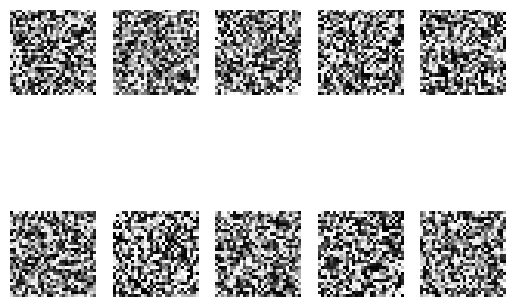

In [11]:
from keras.models import load_model

# Load the trained generator model
generator = load_model('generator_model_test.h5')

# Generate new images
noise = np.random.normal(0, 1, size=(10, 100))
generated_images = generator.predict(noise)

# Rescale images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Plot the generated images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()